# Способ №1 для создания спектрограмм

""" This work is licensed under a Creative Commons Attribution 3.0 Unported License.
    Frank Zalkow, 2012-2013 """

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

In [ ]:
#!/usr/bin/env python
#coding: utf-8
""" This work is licensed under a Creative Commons Attribution 3.0 Unported License.
    Frank Zalkow, 2012-2013 """

import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)    
    
""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)
    
    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]
    
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    plt.clf()

In [ ]:
plotstft("audio.wav")

# Способ №2 для создания спектрограмм

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('audio.wav')
frequencies, times, spectogram = signal.spectrogram(samples, sample_rate)#, window=np.hanning(sample_rate))

print "num of frequencies: ",len(frequencies)
print "num of time bins:   ",len(times)
print "Spectrogram shape:  ",len(spectogram),len(spectogram[0])
#spectogram = spectogram*1000000

plt.figure(figsize=(15, 7.5))
plt.imshow(spectogram, origin="lower", aspect="auto", cmap='jet', interpolation="none")
#plt.pcolormesh(times, frequencies, spectogram)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
spectogram

# Способ №3 для создания спектрограмм

In [17]:
import stft
from scipy import signal
from scipy.io import wavfile
import scipy
import matplotlib.pyplot as plt

In honour of A.Cogliati

In [6]:
flength = 2048
wind = signal.hamming
hopsize = 128

stft.spectrogram(data, framelength=1024, hopsize=None, overlap=None, centered=True, window=None, halved=True, transform=None, padding=0, save_settings=True)

In [14]:
sample_rate, samples = wavfile.read('audio.wav')
spectrogramm = stft.spectrogram(samples, framelength=flength, hopsize=hopsize, window=wind)

In [15]:
print len(spectrogramm), len(spectrogramm[0])
print spectrogramm[500][0]

1025 48097
0j


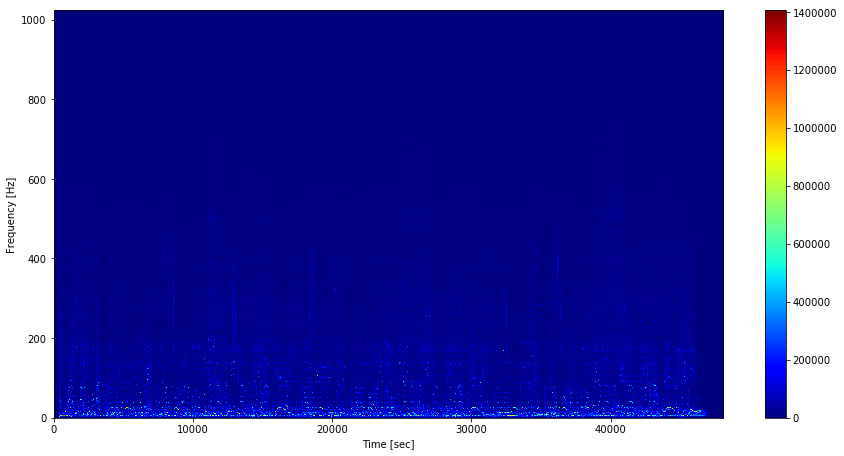

In [22]:
plt.figure(figsize=(15, 7.5))
plt.imshow(scipy.absolute(spectrogramm), origin="lower", cmap="jet",aspect="auto", interpolation="nearest")
#plt.pcolormesh(times, frequencies, spectogram)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [25]:
output = stft.ispectrogram(spectrogramm)
wavfile.write('output.wav', sample_rate, output)